<!-- 
 © Copyright IBM Corporation 2025
 SPDX-License-Identifier: Apache-2.0
 -->


# Terrakit: Labels to dataset pipeline

This notebook demonstrates generating a ML-ready dataset from a collection of labels. The labels used in this example are in GeoJSON format from two wildfire events reported on Copernicus Rapid Mapping Service. The two wildfire events are:

 - [Wildfire in Central Madeira](https://rapidmapping.emergency.copernicus.eu/EMSR748), Portugal, 2024/08/26
 - [Wildfire in Biebrza National Park](https://rapidmapping.emergency.copernicus.eu/EMSR801), Poland, 2025/04/23

<div class="alert alert-block alert-success">
<b>Install Terrakit:</b> For instructions on how to install TerraKit, take a look at the <a href="https://terrastackai.github.io/terrakit/">Welcome</a> page.
</div>

In [1]:
import os

from glob import glob
from pathlib import Path

# Set LOGLEVEL to info for more verbose logging
os.environ["LOGLEVEL"] = "WARNING"

import terrakit

# Import TerraKit Utils
from terrakit.general_utils.labels_downloader import (
    rapid_mapping_geojson_downloader,
    hugging_face_file_downloader,
    EXAMPLE_LABEL_FILES,
    EXAMPLE_RASTER_LABEL_FILES,
)
from terrakit.general_utils.plotting import (
    plot_label_dataframes,
    plot_labels_on_map,
    plot_tiles_and_label_pair,
    plot_chip_and_label_pairs,
)
from terrakit.download.geodata_utils import check_and_crop_bbox

## 1. Process labels
This initial steps takes a directory containing some label files (geojson), and calculates a list of bboxes that encompass the geospatial locations described by the label files. Assuming that the date is included in the label filename, temporal information will also be captured.

The function `process_geojson_labels` returns a Geopandas DataFrame where each row corresponds to a bbox for a given area. The function also saves this information in a shp file. The shp file is output into the working directory (default = `"./tmp"`). 

Either the shp file or the DataFrame can now be used in the next step to tell Terrakit which time and location to download some data from.

In [2]:
# Set a working directory, a dataset name and a directory where some labels can be found
DATASET_NAME = "test_dataset"
WORKING_DIR = f"./tmp/{DATASET_NAME}"
LABELS_FOLDER = "./test_wildfire_vector"


<div class="alert alert-block alert-success">
<b>Example labels:</b> To download a set of example labels, use the `rapid_mapping_geojson_downloader` module.
</div>

In [3]:
# Download some labels if none already exist.
if (
    Path(LABELS_FOLDER).is_dir() is False
    or set(EXAMPLE_LABEL_FILES).issubset(glob(f"{LABELS_FOLDER}/*.json")) is False
):
    rapid_mapping_geojson_downloader(
        event_id="748",
        aoi="01",
        monitoring_number="05",
        version="v1",
        dest=LABELS_FOLDER,
    )
    rapid_mapping_geojson_downloader(
        event_id="801",
        aoi="01",
        monitoring_number="02",
        version="v1",
        dest=LABELS_FOLDER,
    )

.
..
...
>>> Skipping download.
	>>> File already exists: docs/examples/test_wildfire_vector/EMSR748_AOI01_DEL_MONIT05_observedEventA_v1_2024-08-26.json already exists.
.
..
...
>>> Skipping download.
	>>> File already exists: docs/examples/test_wildfire_vector/EMSR801_AOI01_DEL_MONIT02_observedEventA_v1_2025-04-23.json already exists.


In [4]:
# Process the labels by providing a labels folder, working directory and dataset name.
labels_gdf, grouped_bbox_gdf = terrakit.process_labels(
    labels_folder=LABELS_FOLDER,
    dataset_name=DATASET_NAME,
    working_dir=WORKING_DIR,
)
print(labels_gdf)
print(grouped_bbox_gdf)

2026-02-03 23:08:26,820 - INFO - Processing labels with arguments: {'labels_folder': './test_wildfire_vector', 'dataset_name': 'test_dataset', 'working_dir': './tmp/test_dataset', 'active': True, 'label_type': 'vector', 'datetime_info': 'filename'}
2026-02-03 23:08:26,820 - INFO - Processing with parent arguments: dataset_name='test_dataset' working_dir=PosixPath('tmp/test_dataset')
2026-02-03 23:08:26,821 - INFO - Processing labels with arguments: labels_folder=PosixPath('test_wildfire_vector') active=True label_type='vector' datetime_info='filename'
2026-02-03 23:08:26,825 - INFO - Setting datetime to 2025-04-23 and label class to 1 for EMSR801_AOI01_DEL_MONIT02_observedEventA_v1_2025-04-23.json.
2026-02-03 23:08:26,825 - INFO - Successfully processed ./test_wildfire_vector/EMSR801_AOI01_DEL_MONIT02_observedEventA_v1_2025-04-23.json
2026-02-03 23:08:26,843 - INFO - Setting datetime to 2024-08-26 and label class to 1 for EMSR748_AOI01_DEL_MONIT05_observedEventA_v1_2024-08-26.json.
202

    event_type                         obj_desc                 det_method  \
0   8-Wildfire  Land fire: Brush, bush, Pasture  Semi-automatic extraction   
1   8-Wildfire  Land fire: Brush, bush, Pasture  Semi-automatic extraction   
2   8-Wildfire                      Forest Fire  Semi-automatic extraction   
3   8-Wildfire                      Forest Fire  Semi-automatic extraction   
4   8-Wildfire                      Forest Fire  Semi-automatic extraction   
5   8-Wildfire                      Forest Fire  Semi-automatic extraction   
6   8-Wildfire                      Forest Fire  Semi-automatic extraction   
7   8-Wildfire                      Forest Fire  Semi-automatic extraction   
8   8-Wildfire                      Forest Fire  Semi-automatic extraction   
9   8-Wildfire                      Forest Fire  Semi-automatic extraction   
10  8-Wildfire                      Forest Fire  Semi-automatic extraction   
11  8-Wildfire                      Forest Fire  Semi-automatic 

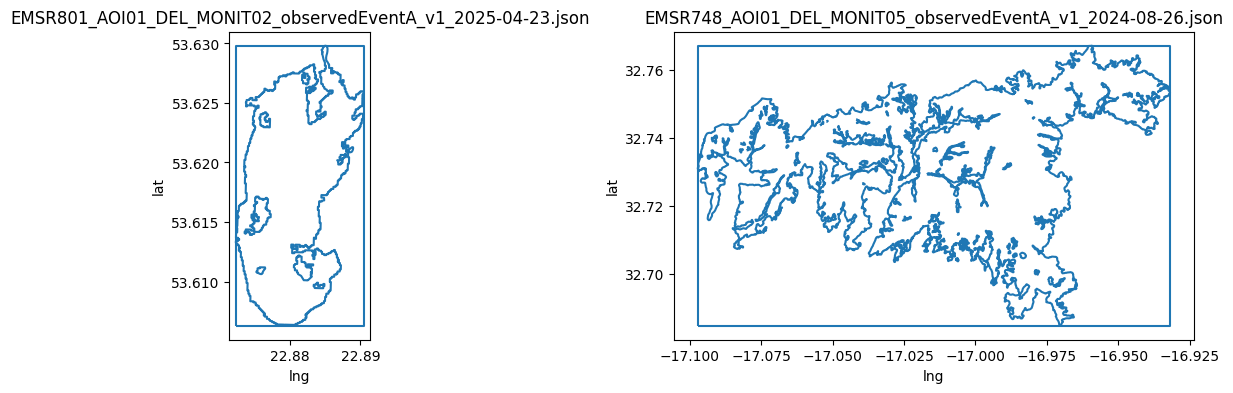

In [5]:
# Plot the process labels and bboxes to confirm they appear as expected.
plot_label_dataframes(labels_gdf, grouped_bbox_gdf)

In [6]:
# Additionally plot labels and bbox on map.
map_collection, title_list = plot_labels_on_map(labels_gdf, grouped_bbox_gdf)
for i in range(0, len(map_collection)):
    print(title_list[i])
    display(map_collection[i])



Download tile bounding box and labels for: EMSR801_AOI01_DEL_MONIT02_observedEventA_v1_2025-04-23.json





Download tile bounding box and labels for: EMSR748_AOI01_DEL_MONIT05_observedEventA_v1_2024-08-26.json



### Multiple label class example

It's also possible to have label files representing different label classes by including the pattern `_CLASS_1_` in the label file name, in this case the label file would represent class index 1. By default the labels will have class index 1 and everything not represented by the labels would have class index 0. There is also the possibility to set anything not represented by a label as no data with class index -1. In the example below there will be two label classes, and with no data for remaining area, which means that classes for labels are indicies 0 and 1.

In [7]:
# Using a separate working directory, dataset name and an example label folder with multiple classes
CLASSES_DATASET_NAME = "class_test_dataset"
CLASSES_WORKING_DIR = f"./tmp/{CLASSES_DATASET_NAME}"
CLASSES_LABELS_FOLDER = "./test_wildfire_classes_vector"


<div class="alert alert-block alert-success">
<b>Example multi-class labels:</b> To download a set of example multi-class labels from EMSR801 wildfire event in Poland (2025), use the `rapid_mapping_geojson_downloader` module. This demonstrates multi-class labeling using multiple spatial features from the same monitoring period (MONIT02, 2025-04-23).
</div>

In [8]:
# Download example multi-class labels from EMSR801 wildfire event (Poland, 2025)
# Using a single monitoring period with multiple spatial features to demonstrate multi-class labeling

# Clean up the labels folder to ensure we start fresh
import json
import os
import shutil

if Path(CLASSES_LABELS_FOLDER).exists():
    shutil.rmtree(CLASSES_LABELS_FOLDER)
Path(CLASSES_LABELS_FOLDER).mkdir(parents=True, exist_ok=True)

# Download MONIT02 from EMSR801 (contains 2 spatial features from same date)
downloaded_file = rapid_mapping_geojson_downloader(
    event_id="801",
    aoi="01",
    monitoring_number="02",
    version="v1",
    dest=CLASSES_LABELS_FOLDER,
)

# Split the downloaded file into separate CLASS files based on features
with open(downloaded_file, "r") as f:
    data = json.load(f)

# Create CLASS_0 file with first feature (large burnt area)
class_0_data = data.copy()
class_0_data["features"] = [data["features"][1]]  # Larger area feature
class_0_file = downloaded_file.replace(
    "_observedEventA_v1_", "_CLASS_0_observedEventA_v1_"
)
with open(class_0_file, "w") as f:
    json.dump(class_0_data, f)

# Create CLASS_1 file with second feature (small burnt area)
class_1_data = data.copy()
class_1_data["features"] = [data["features"][0]]  # Smaller area feature
class_1_file = downloaded_file.replace(
    "_observedEventA_v1_", "_CLASS_1_observedEventA_v1_"
)
with open(class_1_file, "w") as f:
    json.dump(class_1_data, f)

# Remove the original combined file
os.remove(downloaded_file)

print("Created multi-class files from same acquisition date (2025-04-23):")
print(f"  CLASS_0: {Path(class_0_file).name}")
print(f"  CLASS_1: {Path(class_1_file).name}")

.
..
...
>>> Downloading labels from Copernicus Emergency Management Service for: 
	>>> EMSR801 <<<
	>>> AOI01 <<<
	>>> MONIT02 <<<
	>>> observedEventA <<<
	>>> v1 <<<
.
..
...
>>> Requesting event data from:
	>>> https://rapidmapping.emergency.copernicus.eu/backend/EMSR801/AOI01/DEL_MONIT02/EMSR801_AOI01_DEL_MONIT02_v1.zip ... <<<
.
..
...
>>> Extracting event geojson to:
	>>> docs/examples/test_wildfire_classes_vector ... <<<
.
..
...
>>> Label geojson successfully saved:
	>>> acquisition date: 2025-04-23 <<<
	>>> docs/examples/test_wildfire_classes_vector/EMSR801_AOI01_DEL_MONIT02_observedEventA_v1_2025-04-23.json <<<
.
..
...
>>> Downloaded completed successfully <<<
Created multi-class files from same acquisition date (2025-04-23):
  CLASS_0: EMSR801_AOI01_DEL_MONIT02_CLASS_0_observedEventA_v1_2025-04-23.json
  CLASS_1: EMSR801_AOI01_DEL_MONIT02_CLASS_1_observedEventA_v1_2025-04-23.json


In [9]:
# Process the labels by providing a labels folder, working directory and dataset name.
classes_labels_gdf, classes_grouped_bbox_gdf = terrakit.process_labels(
    labels_folder=CLASSES_LABELS_FOLDER,
    dataset_name=CLASSES_DATASET_NAME,
    working_dir=CLASSES_WORKING_DIR,
)
print(classes_labels_gdf)
print(classes_grouped_bbox_gdf)

2026-02-03 23:08:28,502 - INFO - Processing labels with arguments: {'labels_folder': './test_wildfire_classes_vector', 'dataset_name': 'class_test_dataset', 'working_dir': './tmp/class_test_dataset', 'active': True, 'label_type': 'vector', 'datetime_info': 'filename'}
2026-02-03 23:08:28,503 - INFO - Processing with parent arguments: dataset_name='class_test_dataset' working_dir=PosixPath('tmp/class_test_dataset')
2026-02-03 23:08:28,504 - INFO - Processing labels with arguments: labels_folder=PosixPath('test_wildfire_classes_vector') active=True label_type='vector' datetime_info='filename'
2026-02-03 23:08:28,508 - INFO - Setting datetime to 2025-04-23 and label class to 1 for EMSR801_AOI01_DEL_MONIT02_CLASS_1_observedEventA_v1_2025-04-23.json.
2026-02-03 23:08:28,508 - INFO - Successfully processed ./test_wildfire_classes_vector/EMSR801_AOI01_DEL_MONIT02_CLASS_1_observedEventA_v1_2025-04-23.json
2026-02-03 23:08:28,510 - INFO - Setting datetime to 2025-04-23 and label class to 0 for 

   event_type                         obj_desc                 det_method  \
0  8-Wildfire  Land fire: Brush, bush, Pasture  Semi-automatic extraction   
1  8-Wildfire  Land fire: Brush, bush, Pasture  Semi-automatic extraction   

     notation  dmg_src_id        area  \
0  Burnt area           5  175.245428   
1  Burnt area           5    0.040017   

                                            geometry    datetime  \
0  POLYGON ((22.88882 53.62129, 22.88894 53.62128...  2025-04-23   
1  POLYGON ((22.88189 53.62728, 22.8822 53.62728,...  2025-04-23   

                                            filename  labelclass  
0  EMSR801_AOI01_DEL_MONIT02_CLASS_1_observedEven...           1  
1  EMSR801_AOI01_DEL_MONIT02_CLASS_0_observedEven...           0  
   event_type                         obj_desc                 det_method  \
0  8-Wildfire  Land fire: Brush, bush, Pasture  Semi-automatic extraction   
1  8-Wildfire  Land fire: Brush, bush, Pasture  Semi-automatic extraction   

     n

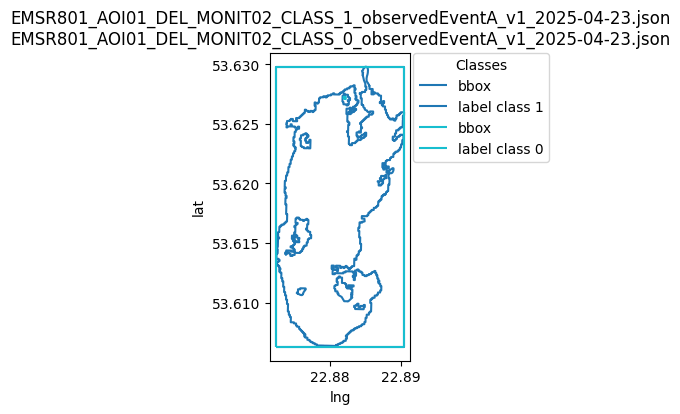

In [10]:
# Plot the process labels and bboxes to confirm they appear as expected.
plot_label_dataframes(classes_labels_gdf, classes_grouped_bbox_gdf)

In [11]:
# Additionally plot labels and bbox on map.
map_collection, title_list = plot_labels_on_map(
    classes_labels_gdf, classes_grouped_bbox_gdf
)
for i in range(0, len(map_collection)):
    print(title_list[i])
    display(map_collection[i])



Download tile bounding box and labels for: EMSR801_AOI01_DEL_MONIT02_CLASS_1_observedEventA_v1_2025-04-23.json,EMSR801_AOI01_DEL_MONIT02_CLASS_0_observedEventA_v1_2025-04-23.json



## 2. Download the data

### Example 2.1: Use a shp file to download data

In [12]:
config = {
    "download": {
        "data_sources": [
            {
                "data_connector": "sentinel_aws",
                "collection_name": "sentinel-2-l2a",
                "bands": ["blue", "green", "red"],
            },
        ],
        "date_allowance": {"pre_days": 0, "post_days": 21},
        "transform": {
            "scale_data_xarray": True,
            "impute_nans": True,
            "reproject": True,
        },
        "max_cloud_cover": 80,
    },
}

queried_data = terrakit.download_data(
    data_sources=config["download"]["data_sources"],
    date_allowance=config["download"]["date_allowance"],
    transform=config["download"]["transform"],
    max_cloud_cover=config["download"]["max_cloud_cover"],
    dataset_name=DATASET_NAME,
    working_dir=WORKING_DIR,
    keep_files=False,
)

2026-02-03 23:08:28,706 - INFO - Processing download_data with arguments: {'data_sources': [{'data_connector': 'sentinel_aws', 'collection_name': 'sentinel-2-l2a', 'bands': ['blue', 'green', 'red']}], 'date_allowance': {'pre_days': 0, 'post_days': 21}, 'transform': {'scale_data_xarray': True, 'impute_nans': True, 'reproject': True}, 'dataset_name': 'test_dataset', 'working_dir': './tmp/test_dataset', 'active': True, 'max_cloud_cover': 80, 'datetime_bbox_shp_file': './tmp/terrakit_curated_dataset_all_bboxes.shp', 'labels_shp_file': './tmp/terrakit_curated_dataset_labels.shp', 'keep_files': False, 'set_no_data': False}
2026-02-03 23:08:28,707 - INFO - Processing with parent arguments: dataset_name='test_dataset' working_dir=PosixPath('tmp/test_dataset')
2026-02-03 23:08:28,707 - INFO - Processing download_data with arguments: {'pipeline_model': PipelineModel(dataset_name='test_dataset', working_dir=PosixPath('tmp/test_dataset')), 'date_allowance': {'pre_days': 0, 'post_days': 21}, 'trans

[########################################] | 100% Completed | 2.40 ss


2026-02-03 23:08:37,334 - INFO - Saving cloud optimized geotiff to tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23.tif
2026-02-03 23:08:37,365 - INFO - Imputing NaNs in xarray data array.
2026-02-03 23:08:37,366 - INFO - Skipping imputation as no nodata pixels found
2026-02-03 23:08:37,366 - INFO - Saving cloud optimized geotiff to tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif
2026-02-03 23:08:37,386 - INFO - Deleting tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23.tif
2026-02-03 23:08:37,387 - INFO - Queried data: ['tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif']
2026-02-03 23:08:37,387 - INFO - Initializing DataConnector with connector type: sentinel_aws
2026-02-03 23:08:37,387 - INFO - sentinel_aws
2026-02-03 23:08:37,389 - INFO - sentinel_aws
2026-02-03 23:08:37,389 - INFO - sentinel-2-l2a
2026-02-03 23:08:37,390 - INFO - 2024-08-26
2026-02-03 23:08:37,390 - INFO - 2024-09-16
2026-02-03 23:08:37,390 - INFO - [-17.097259995

[########################################] | 100% Completed | 3.97 sms


2026-02-03 23:08:46,910 - INFO - Saving cloud optimized geotiff to tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30.tif
2026-02-03 23:08:47,285 - INFO - Imputing NaNs in xarray data array.
2026-02-03 23:08:47,287 - INFO - Skipping imputation as no nodata pixels found
2026-02-03 23:08:47,287 - INFO - Saving cloud optimized geotiff to tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30_imputed.tif
2026-02-03 23:08:47,652 - INFO - Deleting tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30.tif
2026-02-03 23:08:47,653 - INFO - Queried data: ['tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif', 'tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30_imputed.tif']
2026-02-03 23:08:47,666 - INFO - Rasterizing vectors to the queried data
2026-02-03 23:08:47,666 - INFO - Label classes being used: [1]
2026-02-03 23:08:47,675 - INFO - Writing to tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_labels.tif
2026-02-03 23:08:47,702 - INFO - Writing to

### 2.2: Inspect the data
Use the `plot_tiles_and_label_pair` function to inspect the downloaded tiles and corresponding labels.

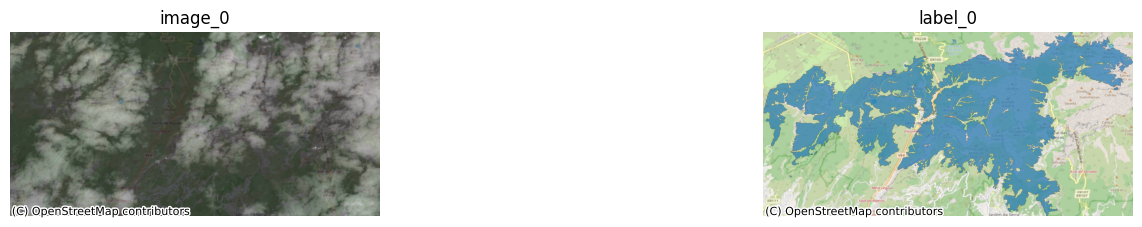

Legend
image_0: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed.tif, label_0: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_labels.tif
---


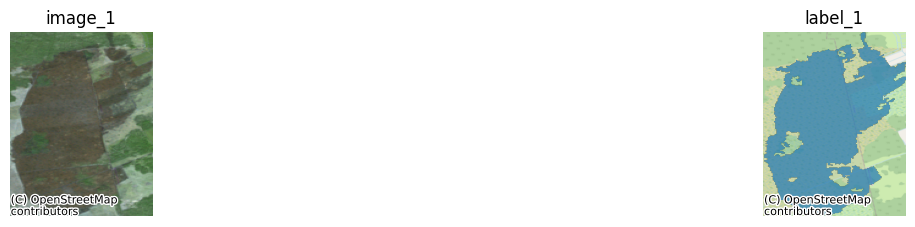

Legend
image_1: sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif, label_1: sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_labels.tif
---


In [13]:
plot_tiles_and_label_pair(
    queried_data, bands=config["download"]["data_sources"][0]["bands"]
)

### Example 2.3: Download data for multi-class labels
Now let's download data for the multi-class labels we processed earlier. 

**Important:** When working with multi-class labels, we use the `set_no_data=True` parameter. This ensures that areas not covered by any label class are marked as no-data (class -1) rather than being assigned to class 0. This is crucial for multi-class classification where class 0 represents a valid label class.

In [14]:
config_classes = {
    "download": {
        "data_sources": [
            {
                "data_connector": "sentinel_aws",
                "collection_name": "sentinel-2-l2a",
                "bands": ["blue", "green", "red"],
            },
        ],
        "date_allowance": {"pre_days": 0, "post_days": 21},
        "transform": {
            "scale_data_xarray": True,
            "impute_nans": True,
            "reproject": True,
        },
        "max_cloud_cover": 80,
    },
}

# Note: set_no_data=True is critical for multi-class labels
# This sets unlabeled areas to -1 (no-data) instead of 0 (which is a valid class)
queried_data_classes = terrakit.download_data(
    data_sources=config_classes["download"]["data_sources"],
    date_allowance=config_classes["download"]["date_allowance"],
    transform=config_classes["download"]["transform"],
    max_cloud_cover=config_classes["download"]["max_cloud_cover"],
    dataset_name=CLASSES_DATASET_NAME,
    working_dir=CLASSES_WORKING_DIR,
    keep_files=False,
    set_no_data=True,  # Set unlabeled areas as no-data (-1) for multi-class
)

2026-02-03 23:08:50,114 - INFO - Processing download_data with arguments: {'data_sources': [{'data_connector': 'sentinel_aws', 'collection_name': 'sentinel-2-l2a', 'bands': ['blue', 'green', 'red']}], 'date_allowance': {'pre_days': 0, 'post_days': 21}, 'transform': {'scale_data_xarray': True, 'impute_nans': True, 'reproject': True}, 'dataset_name': 'class_test_dataset', 'working_dir': './tmp/class_test_dataset', 'active': True, 'max_cloud_cover': 80, 'datetime_bbox_shp_file': './tmp/terrakit_curated_dataset_all_bboxes.shp', 'labels_shp_file': './tmp/terrakit_curated_dataset_labels.shp', 'keep_files': False, 'set_no_data': True}
2026-02-03 23:08:50,114 - INFO - Processing with parent arguments: dataset_name='class_test_dataset' working_dir=PosixPath('tmp/class_test_dataset')
2026-02-03 23:08:50,114 - INFO - Processing download_data with arguments: {'pipeline_model': PipelineModel(dataset_name='class_test_dataset', working_dir=PosixPath('tmp/class_test_dataset')), 'date_allowance': {'pre

[########################################] | 100% Completed | 106.61 ms


2026-02-03 23:08:55,810 - INFO - Saving cloud optimized geotiff to tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23.tif
2026-02-03 23:08:55,836 - INFO - Imputing NaNs in xarray data array.
2026-02-03 23:08:55,836 - INFO - Skipping imputation as no nodata pixels found
2026-02-03 23:08:55,837 - INFO - Saving cloud optimized geotiff to tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif
2026-02-03 23:08:55,857 - INFO - Deleting tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23.tif
2026-02-03 23:08:55,858 - INFO - Queried data: ['tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif']
2026-02-03 23:08:55,860 - INFO - Rasterizing vectors to the queried data
2026-02-03 23:08:55,860 - INFO - Label classes being used: [0 1]
2026-02-03 23:08:55,863 - INFO - Writing to tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_labels.tif
2026-02-03 23:08:55,864 - INFO - Successfully rasterized 1 files


### Example 2.4: Inspect the data for multi-class labels
Use the `plot_tiles_and_label_pair` function to inspect the downloaded tiles and corresponding multi-class labels. 

**Important:** Since we used `set_no_data=True` during download, we need to pass `no_data_value=-1` to the plotting function so it correctly treats -1 as the background (not class 0, which is a valid label class). You should see two distinct label classes (0 and 1) representing different burnt area features.

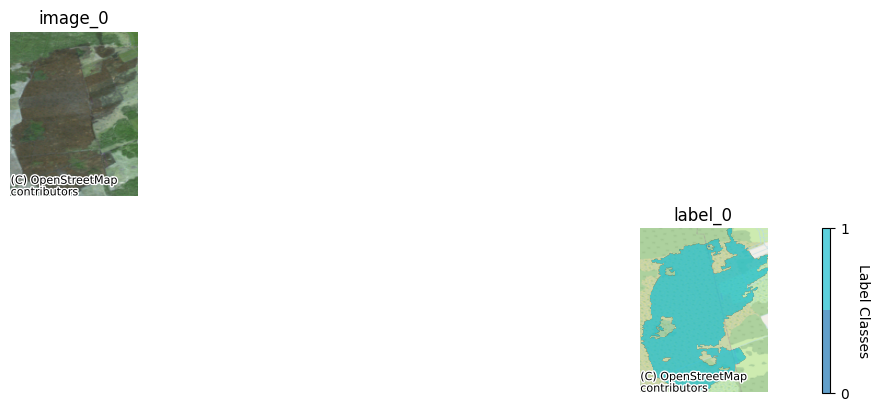

Legend
image_0: sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif, label_0: sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_labels.tif
---


In [15]:
plot_tiles_and_label_pair(
    queried_data_classes,
    bands=config_classes["download"]["data_sources"][0]["bands"],
    no_data_value=-1,  # Set to -1 because we used set_no_data=True in download
)

## 3. Chip the data
Now that the tiled data has been downloaded, let's chip it accordingly.

#### 3.1 Example 1: Use the queried data list returned from download_data to find the files to chip.

In [16]:
chip_args = {
    "chip": {"sample_dim": 256},
}

res = terrakit.chip_and_label_data(
    dataset_name=DATASET_NAME,
    sample_dim=chip_args["chip"]["sample_dim"],
    queried_data=queried_data,
    working_dir=WORKING_DIR,
)

# Note that we can use the working directory to find the list of files to chip.
# Uncomment to try this out.
# res = terrakit.chip_and_label_data(
#     dataset_name=DATASET_NAME,
#     working_dir=WORKING_DIR,
#     sample_dim=chip_args["chip"]["sample_dim"],
#     keep_files=True,
# )

2026-02-03 23:08:56,144 - INFO - Processing labels with arguments: {'dataset_name': 'test_dataset', 'working_dir': './tmp/test_dataset', 'active': True, 'data_suffix': '.tif', 'label_suffix': '_labels.tif', 'chip_suffix': '.data.tif', 'chip_label_suffix': '.label.tif', 'sample_dim': 256, 'queried_data': ['tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif', 'tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30_imputed.tif'], 'keep_files': True, 'match_suffix': True, 'stats': True}
2026-02-03 23:08:56,145 - INFO - Processing with parent arguments: dataset_name='test_dataset' working_dir=PosixPath('tmp/test_dataset')
2026-02-03 23:08:56,145 - INFO - Chipping data with arguments: active=True data_suffix='.tif' label_suffix='_labels.tif' chip_suffix='.data.tif' chip_label_suffix='.label.tif' sample_dim=256 queried_data=['tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif', 'tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30_imputed.tif'] keep_files

### Check the results
Use the `plot_chip_and_label_pairs` function to check the chip and label pairs look as expected.

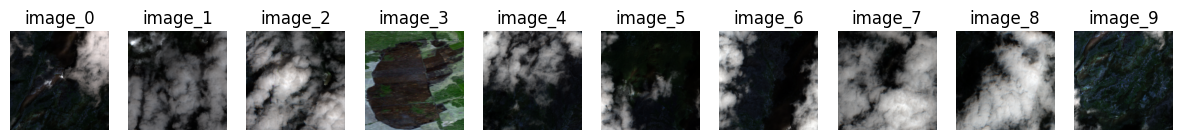

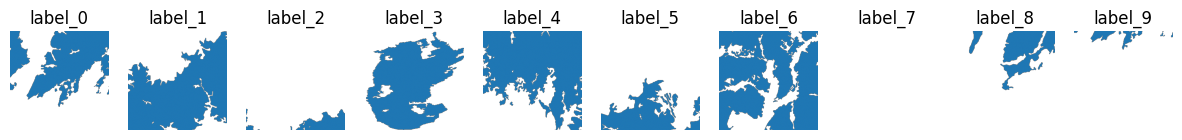

Legend
image_0: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_10.data.tif
image_1: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_16.data.tif
image_2: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_4.data.tif
image_3: sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_0.data.tif
image_4: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_14.data.tif
image_5: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_8.data.tif
image_6: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_9.data.tif
image_7: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_23.data.tif
image_8: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_2.data.tif
image_9: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_11.data.tif
---
label_0: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_10.label.tif
label_1: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_16.label.tif
label_2: sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_4.label.tif
label_3: sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_0.label.tif
label_4: sentinel_aws_sentinel-2-l2a_202

In [17]:
plot_chip_and_label_pairs(
    res, bands=config["download"]["data_sources"][0]["bands"], samples=10
)

### Example 3.2: Chip the multi-class data
Now let's chip the multi-class data we downloaded earlier.

In [18]:
# Check the tile dimensions before chipping
import rasterio

with rasterio.open(queried_data_classes[0]) as src:
    print(f"Tile dimensions: {src.width} x {src.height}")
    print(f"Tile shape: {src.shape}")

# Use smaller chip size (128) since this example has a small area (~117x255 pixels)
# This will create multiple chips for demonstration purposes
chip_args_classes = {
    "chip": {"sample_dim": 128},
}

res_classes = terrakit.chip_and_label_data(
    dataset_name=CLASSES_DATASET_NAME,
    sample_dim=chip_args_classes["chip"]["sample_dim"],
    queried_data=queried_data_classes,
    working_dir=CLASSES_WORKING_DIR,
)

print(f"\nTotal files returned: {len(res_classes)}")
print(f"Files: {res_classes}")

2026-02-03 23:08:56,634 - INFO - Processing labels with arguments: {'dataset_name': 'class_test_dataset', 'working_dir': './tmp/class_test_dataset', 'active': True, 'data_suffix': '.tif', 'label_suffix': '_labels.tif', 'chip_suffix': '.data.tif', 'chip_label_suffix': '.label.tif', 'sample_dim': 128, 'queried_data': ['tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif'], 'keep_files': True, 'match_suffix': True, 'stats': True}
2026-02-03 23:08:56,635 - INFO - Processing with parent arguments: dataset_name='class_test_dataset' working_dir=PosixPath('tmp/class_test_dataset')
2026-02-03 23:08:56,635 - INFO - Chipping data with arguments: active=True data_suffix='.tif' label_suffix='_labels.tif' chip_suffix='.data.tif' chip_label_suffix='.label.tif' sample_dim=128 queried_data=['tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif'] keep_files=True match_suffix=True
2026-02-03 23:08:56,636 - INFO - Found candidate files to chip: ['tmp/class_test_d

Tile dimensions: 117 x 255
Tile shape: (255, 117)


  0%|          | 0/1 [00:00<?, ?it/s]2026-02-03 23:08:56,637 - INFO - .tif
2026-02-03 23:08:56,637 - INFO - tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif
2026-02-03 23:08:56,637 - INFO - tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed
2026-02-03 23:08:56,638 - INFO - tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_labels.tif
2026-02-03 23:08:56,638 - INFO - tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed
2026-02-03 23:08:56,638 - INFO - Chipping data: tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed.tif
2026-02-03 23:08:56,647 - INFO - Chipping label data: tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_labels.tif
100%|██████████| 1/1 [00:00<00:00, 85.33it/s]
2026-02-03 23:08:56,649 - INFO - finished chipping ['tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_0.data.tif', 'tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04


Total files returned: 4
Files: ['tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_0.data.tif', 'tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_1.data.tif', 'tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_0.label.tif', 'tmp/class_test_dataset/sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_1.label.tif']


### Check the multi-class chip results
Use the `plot_chip_and_label_pairs` function to check the multi-class chip and label pairs. You should see chips with labels showing different classes (0 and 1) in different colors.

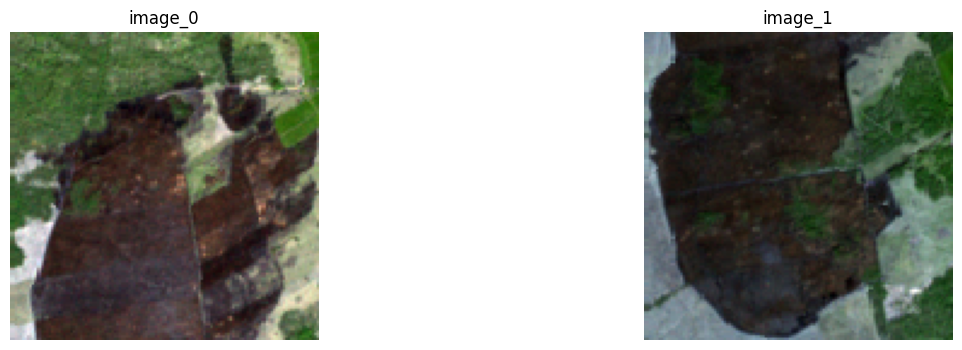

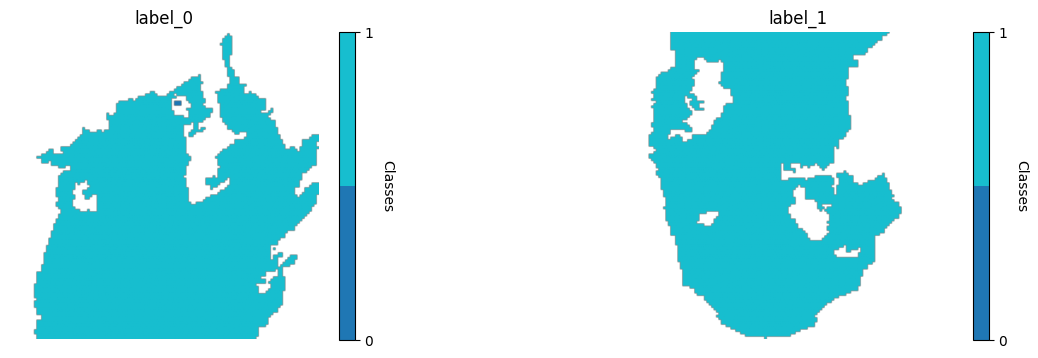

Legend
image_0: sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_0.data.tif
image_1: sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_1.data.tif
---
label_0: sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_0.label.tif
label_1: sentinel_aws_sentinel-2-l2a_2025-04-23_imputed_1.label.tif


In [19]:
plot_chip_and_label_pairs(
    res_classes,
    bands=config_classes["download"]["data_sources"][0]["bands"],
    samples=10,
    no_data_value=-1,  # Set to -1 because we used set_no_data=True in download
)

## 4. Store

In [20]:
terrakit.taco_store_data(
    dataset_name=DATASET_NAME,
    working_dir=WORKING_DIR,
    save_dir=WORKING_DIR,
    tortilla_name="terrakit_curated_dataset.tortilla",
)

2026-02-03 23:08:57,037 - INFO - Processing with parent arguments: dataset_name='test_dataset' working_dir=PosixPath('tmp/test_dataset')
2026-02-03 23:08:57,038 - INFO - Storing data with arguments: active=True format='taco' dataset_save_dir='.' save_dir='./tmp/test_dataset' tortilla_name='terrakit_curated_dataset.tortilla' statistics=True include_config=True check_dataset=True
2026-02-03 23:08:57,039 - INFO - ['./tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_0.data.tif', './tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_1.data.tif', './tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_10.data.tif', './tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_11.data.tif', './tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_12.data.tif', './tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_13.data.tif', './tmp/test_dataset/sentinel_aws_sentinel-2-l2a_2024-08-30_imputed_14.data.tif', './tmp/test_dataset/

Reading metadata from samples...



Making a tortilla 🫓: 100%|██████████| 25/25 [00:00<00:00, 2726.26file/s]


'./tmp/test_dataset/terrakit_curated_dataset.tortilla'

In [21]:
import pandas as pd
import tacoreader

df = tacoreader.load("./tmp/test_dataset/terrakit_curated_dataset.tortilla")
splits = ["train", "validation", "test"]
sample_rows = []

for split in splits:
    subset = df[df["tortilla:data_split"] == split]
    if not subset.empty:
        sample_rows.append(subset.iloc[0])  # Take first row

# Create a new DataFrame
sample_df = pd.DataFrame(sample_rows)

# Save back to a new file
tacoreader.compile(sample_df, "./tmp/test_dataset/sampled_dataset.tortilla")

Baking a tortilla 🫓: 100%|██████████| 3/3 [00:00<00:00, 88612.06file/s]


PosixPath('tmp/test_dataset/sampled_dataset.tortilla')

## 5. Upload

## 6. Additional utility functions

In [22]:
check_and_crop_bbox(bbox=[-73.645550, 44.233885, -72.539635, 44.278023], resolution=10)

2026-02-03 23:09:06,143 - INFO - Dimension less than 244, will pad - (2, 491)
2026-02-03 23:09:06,143 - INFO - New dimensions are (310, 500)


([BBox(((-73.64555, 44.233885), (-73.36960432686855, 44.278023)), crs=CRS('4326')),
  BBox(((-73.36960432686855, 44.233885), (-73.0936586537371, 44.278023)), crs=CRS('4326')),
  BBox(((-73.0936586537371, 44.233885), (-72.81771298060565, 44.278023)), crs=CRS('4326')),
  BBox(((-72.81771298060565, 44.233885), (-72.5417673074742, 44.278023)), crs=CRS('4326')),
  BBox(((-72.56101965371401, 44.233885), (-72.5203826537602, 44.278023)), crs=CRS('4326'))],
 [(2194, 530), (2192, 538), (2191, 545), (2189, 553), (310, 500)])

# Raster Labels to Data
Let's take a quick look at how we can also use TerraKit to generating a ML-ready dataset from a collection of raster labels. 

The label used in this section are in raster format from two burn scar events included in the [`ibm-nasa-geospatial/hls_burn_scars`](https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars) hugging face dataset.

## 1. Process raster labels
As before, this initial steps takes a directory containing some label files. This time the labels are raster files (.tif). The date is assumed to be contained in the filename again. Supported date types are `YYYYDDD (7), YYYYMMDD (8), YYMMDD (6 -> 20YYMMDD).`

In [23]:
# Set a working directory, a dataset name and a directory where some labels can be found
DATASET_NAME_RASTER = "test_dataset_raster"
WORKING_DIR_RASTER = f"./tmp/{DATASET_NAME_RASTER}"
LABELS_FOLDER_RASTER = "./test_burn_scar_raster"


<div class="alert alert-block alert-success">
<b>Example labels:</b> To download a set of example raster labels, use the `hugging_face_file_downloader` function.
</div>

In [24]:
if (
    Path(LABELS_FOLDER_RASTER).is_dir() is False
    or set(EXAMPLE_RASTER_LABEL_FILES).issubset(glob(f"{LABELS_FOLDER_RASTER}/*.tif"))
    is False
):
    for filename in EXAMPLE_RASTER_LABEL_FILES:
        hugging_face_file_downloader(
            repo_id="ibm-nasa-geospatial/hls_burn_scars",
            filename=filename,
            revision="e48662b31288f1d5f1fd5cf5ebb0e454092a19ce",
            subfolder="training",
            dest=LABELS_FOLDER_RASTER,
        )

2026-02-03 23:09:06,381 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars/resolve/e48662b31288f1d5f1fd5cf5ebb0e454092a19ce/training/subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4.mask.tif "HTTP/1.1 302 Found"
2026-02-03 23:09:06,499 - INFO - HTTP Request: GET https://huggingface.co/api/datasets/ibm-nasa-geospatial/hls_burn_scars/xet-read-token/e48662b31288f1d5f1fd5cf5ebb0e454092a19ce "HTTP/1.1 200 OK"


training/subsetted_512x512_HLS.S30.T10SE(…):   0%|          | 0.00/525k [00:00<?, ?B/s]

2026-02-03 23:09:07,425 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars/resolve/e48662b31288f1d5f1fd5cf5ebb0e454092a19ce/training/subsetted_512x512_HLS.S30.T10SGD.2021306.v1.4.mask.tif "HTTP/1.1 302 Found"


.
..
...
>>> Label successfully saved<<<
.
..
...
>>> Downloaded completed successfully <<<


training/subsetted_512x512_HLS.S30.T10SG(…):   0%|          | 0.00/525k [00:00<?, ?B/s]

.
..
...
>>> Label successfully saved<<<
.
..
...
>>> Downloaded completed successfully <<<


In [25]:
labels_gdf, grouped_bbox_gdf = terrakit.process_labels(
    labels_folder=LABELS_FOLDER_RASTER,
    dataset_name=DATASET_NAME_RASTER,
    working_dir=WORKING_DIR_RASTER,
    label_type="raster",
)
print(labels_gdf)
print(grouped_bbox_gdf)

2026-02-03 23:09:07,756 - INFO - Processing labels with arguments: {'labels_folder': './test_burn_scar_raster', 'dataset_name': 'test_dataset_raster', 'working_dir': './tmp/test_dataset_raster', 'active': True, 'label_type': 'raster', 'datetime_info': 'filename'}
2026-02-03 23:09:07,756 - INFO - Processing with parent arguments: dataset_name='test_dataset_raster' working_dir=PosixPath('tmp/test_dataset_raster')
2026-02-03 23:09:07,757 - INFO - Processing labels with arguments: labels_folder=PosixPath('test_burn_scar_raster') active=True label_type='raster' datetime_info='filename'
2026-02-03 23:09:07,772 - INFO - Setting datetime to 2018-09-02 and label class to 1 for subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4.mask.tif.
2026-02-03 23:09:07,773 - INFO - Successfully processed ./test_burn_scar_raster/subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4.mask.tif
2026-02-03 23:09:07,780 - INFO - Setting datetime to 2021-11-02 and label class to 1 for subsetted_512x512_HLS.S30.T10SGD.2021306.v1

   value                                           geometry    datetime  \
0    1.0  POLYGON ((-122.0214 38.3242, -122.0214 38.3239...  2018-09-02   
1    1.0  POLYGON ((-120.09659 34.52628, -120.0966 34.52...  2021-11-02   

                                            filename  labelclass  
0  subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4....           1  
1  subsetted_512x512_HLS.S30.T10SGD.2021306.v1.4....           1  
   value                                           geometry    datetime  \
0    1.0  POLYGON ((-121.96386 38.29958, -121.96386 38.3...  2018-09-02   
1    1.0  POLYGON ((-120.02134 34.46043, -120.02134 34.5...  2021-11-02   

                                            filename  labelclass  
0  subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4....           1  
1  subsetted_512x512_HLS.S30.T10SGD.2021306.v1.4....           1  


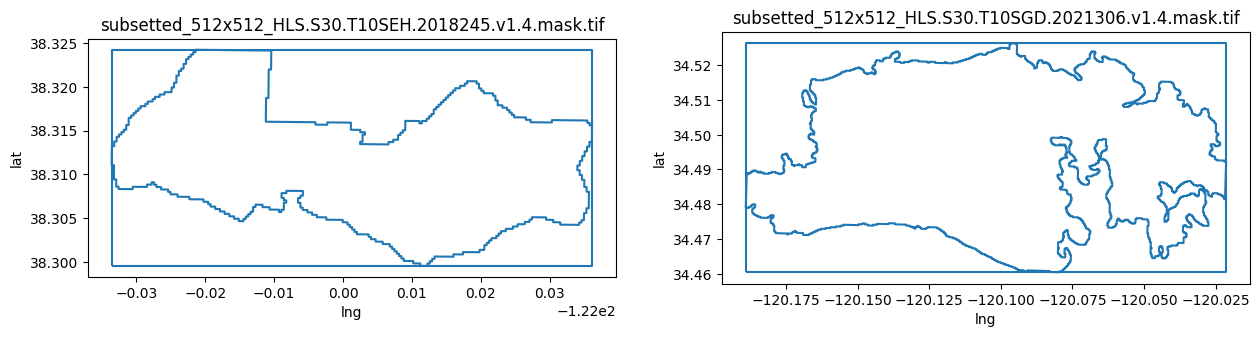

In [26]:
plot_label_dataframes(labels_gdf, grouped_bbox_gdf)

## 2. Download the data

In [27]:
config = {
    "download": {
        "data_sources": [
            {
                "data_connector": "sentinel_aws",
                "collection_name": "sentinel-2-l2a",
                "bands": ["blue", "green", "red"],
            },
        ],
        "date_allowance": {"pre_days": 0, "post_days": 21},
        "transform": {
            "scale_data_xarray": True,
            "impute_nans": True,
            "reproject": True,
        },
        "max_cloud_cover": 80,
    },
}
queried_data = terrakit.download_data(
    data_sources=config["download"]["data_sources"],
    date_allowance=config["download"]["date_allowance"],
    transform=config["download"]["transform"],
    max_cloud_cover=config["download"]["max_cloud_cover"],
    dataset_name=DATASET_NAME_RASTER,
    working_dir=WORKING_DIR_RASTER,
    keep_files=False,
)

2026-02-03 23:09:07,986 - INFO - Processing download_data with arguments: {'data_sources': [{'data_connector': 'sentinel_aws', 'collection_name': 'sentinel-2-l2a', 'bands': ['blue', 'green', 'red']}], 'date_allowance': {'pre_days': 0, 'post_days': 21}, 'transform': {'scale_data_xarray': True, 'impute_nans': True, 'reproject': True}, 'dataset_name': 'test_dataset_raster', 'working_dir': './tmp/test_dataset_raster', 'active': True, 'max_cloud_cover': 80, 'datetime_bbox_shp_file': './tmp/terrakit_curated_dataset_all_bboxes.shp', 'labels_shp_file': './tmp/terrakit_curated_dataset_labels.shp', 'keep_files': False, 'set_no_data': False}
2026-02-03 23:09:07,986 - INFO - Processing with parent arguments: dataset_name='test_dataset_raster' working_dir=PosixPath('tmp/test_dataset_raster')
2026-02-03 23:09:07,986 - INFO - Processing download_data with arguments: {'pipeline_model': PipelineModel(dataset_name='test_dataset_raster', working_dir=PosixPath('tmp/test_dataset_raster')), 'date_allowance'

[########################################] | 100% Completed | 3.14 ss


2026-02-03 23:09:16,921 - INFO - Saving cloud optimized geotiff to tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02.tif
2026-02-03 23:09:17,007 - INFO - Imputing NaNs in xarray data array.
2026-02-03 23:09:17,007 - INFO - Skipping imputation as no nodata pixels found
2026-02-03 23:09:17,008 - INFO - Saving cloud optimized geotiff to tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed.tif
2026-02-03 23:09:17,069 - INFO - Deleting tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02.tif
2026-02-03 23:09:17,070 - INFO - Queried data: ['tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed.tif']
2026-02-03 23:09:17,070 - INFO - Initializing DataConnector with connector type: sentinel_aws
2026-02-03 23:09:17,070 - INFO - sentinel_aws
2026-02-03 23:09:17,071 - INFO - sentinel_aws
2026-02-03 23:09:17,073 - INFO - sentinel-2-l2a
2026-02-03 23:09:17,073 - INFO - 2021-11-02
2026-02-03 23:09:17,073 - INFO - 2021-11-23
2026-02-03 23:09:17

[########################################] | 100% Completed | 5.88 sms


2026-02-03 23:09:28,476 - INFO - Saving cloud optimized geotiff to tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2021-11-02.tif
2026-02-03 23:09:28,736 - INFO - Imputing NaNs in xarray data array.
2026-02-03 23:09:28,737 - INFO - Skipping imputation as no nodata pixels found
2026-02-03 23:09:28,738 - INFO - Saving cloud optimized geotiff to tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2021-11-02_imputed.tif
2026-02-03 23:09:28,978 - INFO - Deleting tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2021-11-02.tif
2026-02-03 23:09:28,978 - INFO - Queried data: ['tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed.tif', 'tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2021-11-02_imputed.tif']
2026-02-03 23:09:28,986 - INFO - Rasterizing vectors to the queried data
2026-02-03 23:09:28,987 - INFO - Label classes being used: [1]
2026-02-03 23:09:28,990 - INFO - Writing to tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed_labels.tif
2

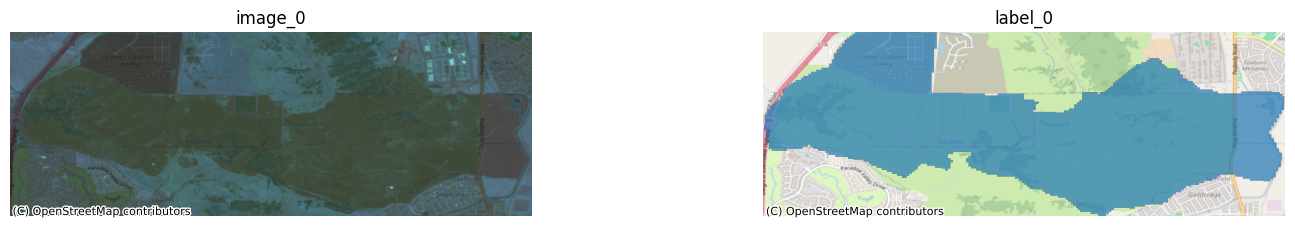

Legend
image_0: sentinel_aws_sentinel-2-l2a_2018-09-02_imputed.tif, label_0: sentinel_aws_sentinel-2-l2a_2018-09-02_imputed_labels.tif
---


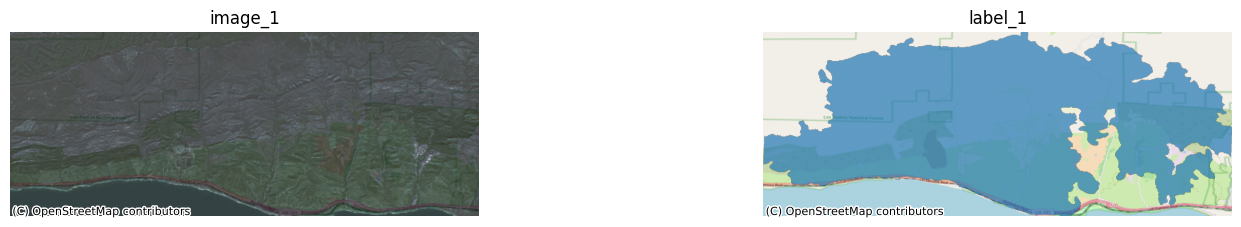

Legend
image_1: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed.tif, label_1: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_labels.tif
---


In [28]:
plot_tiles_and_label_pair(
    queried_data, bands=config["download"]["data_sources"][0]["bands"]
)

## 3. Chip the data
Now that the tiled data has been downloaded, let's chip it accordingly.

In [29]:
chip_args = {
    "chip": {"sample_dim": 256},
}

res = terrakit.chip_and_label_data(
    dataset_name=DATASET_NAME_RASTER,
    sample_dim=chip_args["chip"]["sample_dim"],
    queried_data=queried_data,
    working_dir=WORKING_DIR_RASTER,
)

2026-02-03 23:09:30,887 - INFO - Processing labels with arguments: {'dataset_name': 'test_dataset_raster', 'working_dir': './tmp/test_dataset_raster', 'active': True, 'data_suffix': '.tif', 'label_suffix': '_labels.tif', 'chip_suffix': '.data.tif', 'chip_label_suffix': '.label.tif', 'sample_dim': 256, 'queried_data': ['tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed.tif', 'tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2021-11-02_imputed.tif'], 'keep_files': True, 'match_suffix': True, 'stats': True}
2026-02-03 23:09:30,887 - INFO - Processing with parent arguments: dataset_name='test_dataset_raster' working_dir=PosixPath('tmp/test_dataset_raster')
2026-02-03 23:09:30,888 - INFO - Chipping data with arguments: active=True data_suffix='.tif' label_suffix='_labels.tif' chip_suffix='.data.tif' chip_label_suffix='.label.tif' sample_dim=256 queried_data=['tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed.tif', 'tmp/test_dataset_raster/sentine

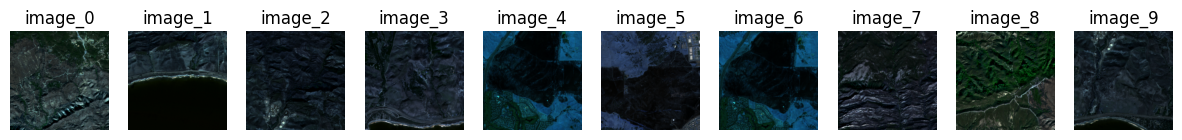

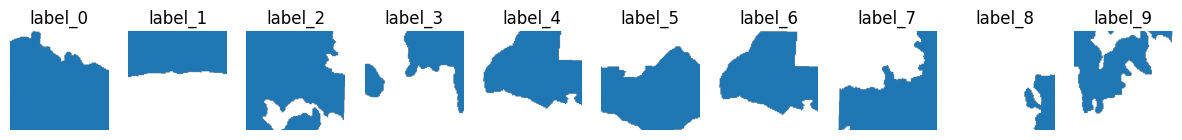

Legend
image_0: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_9.data.tif
image_1: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_5.data.tif
image_2: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_16.data.tif
image_3: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_14.data.tif
image_4: sentinel_aws_sentinel-2-l2a_2018-09-02_imputed_1.data.tif
image_5: sentinel_aws_sentinel-2-l2a_2018-09-02_imputed_2.data.tif
image_6: sentinel_aws_sentinel-2-l2a_2018-09-02_imputed_0.data.tif
image_7: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_1.data.tif
image_8: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_0.data.tif
image_9: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_17.data.tif
---
label_0: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_9.label.tif
label_1: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_5.label.tif
label_2: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_16.label.tif
label_3: sentinel_aws_sentinel-2-l2a_2021-11-02_imputed_14.label.tif
label_4: sentinel_aws_sentinel-2-l2a_2018-

In [30]:
plot_chip_and_label_pairs(
    res, bands=config["download"]["data_sources"][0]["bands"], samples=10
)

## 4. Store

In [31]:
terrakit.taco_store_data(
    dataset_name=DATASET_NAME_RASTER,
    working_dir=WORKING_DIR_RASTER,
    save_dir=WORKING_DIR_RASTER,
    tortilla_name="terrakit_curated_dataset.tortilla",
)

2026-02-03 23:09:31,420 - INFO - Processing with parent arguments: dataset_name='test_dataset_raster' working_dir=PosixPath('tmp/test_dataset_raster')
2026-02-03 23:09:31,420 - INFO - Storing data with arguments: active=True format='taco' dataset_save_dir='.' save_dir='./tmp/test_dataset_raster' tortilla_name='terrakit_curated_dataset.tortilla' statistics=True include_config=True check_dataset=True
2026-02-03 23:09:31,421 - INFO - ['./tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed_0.data.tif', './tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed_1.data.tif', './tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed_2.data.tif', './tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed_3.data.tif', './tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed_4.data.tif', './tmp/test_dataset_raster/sentinel_aws_sentinel-2-l2a_2018-09-02_imputed_5.data.tif', './tmp/test_dataset_raster/sentinel_aws_se

Reading metadata from samples...



Making a tortilla: 100%|██████████| 24/24 [00:00<00:00, 2102.67file/s]


'./tmp/test_dataset_raster/terrakit_curated_dataset.tortilla'